In [1]:
!pip install pypulseq==1.3.1.post1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

Syntaxfehler.
Syntaxfehler.
Syntaxfehler.


In [2]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'exD01_bSSFP_2D'

c:\Users\endresjn\Documents\MRzero\MRzero-Core\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


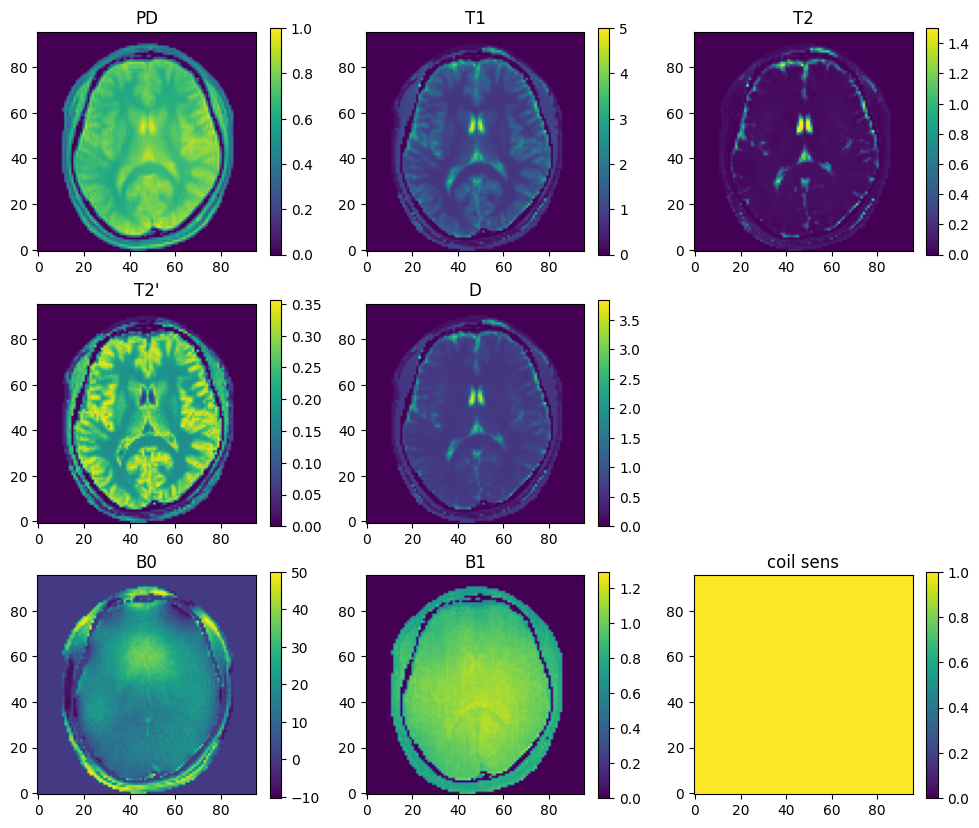

VoxelGridPhantom
size = tensor([0.1920, 0.1920, 0.1920])


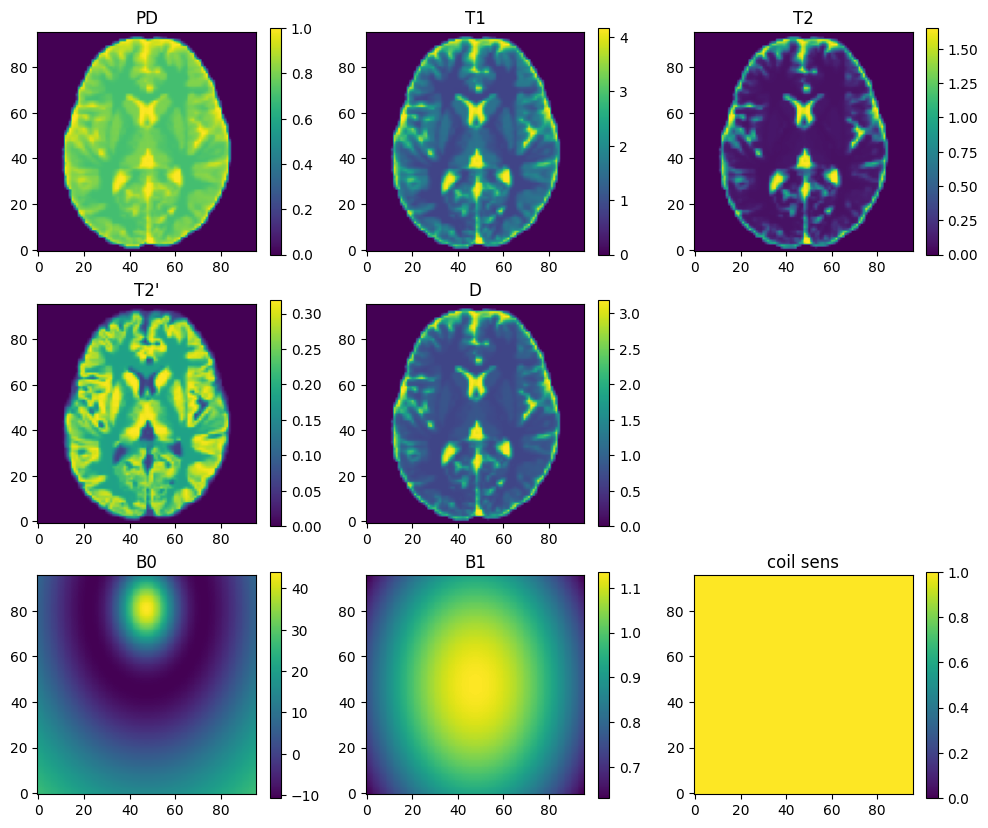

In [3]:
path = "W:/radiologie/mr-physik-data/Mitarbeiter/Zaiss_AG/Vorträge Gruppensitzung AG Zaiss/Konferenzbeiträge/2024_ESMRMB/Endres_ESMRMB2024-0382_PDG_motion/"
data = torch.load(path + "nam.pt").detach()
data_B0 = torch.load(path + "nam_B0.pt").detach()
data_acs = torch.load(path + "image_acs.pt").detach()

PD = data_acs / data_acs.max()
PD[PD < 0.2] = 0
T1 = data[..., 0].clamp(0, 5)
T2 = data[..., 1].clamp(0, 1.5)
T2dash = data[..., 2].clamp(0, 0.5)
B1 = data[..., 3].clamp(0, 1.5)[None, ...]
D = data[..., 4].clamp(0, 4)
B0 = data_B0[..., 0].clamp(-50, 50)
coil_sens = torch.ones(1, *PD.shape)

mask = PD > 0.2
PD[~mask] = 0
T1[~mask] = 0
T2[~mask] = 0
T2dash[~mask] = 0
D[~mask] = 0
B0[~mask] = 0
B1[:, ~mask] = 0


nam_phantom = mr0.VoxelGridPhantom(PD, T1, T2, T2dash, D, B0, B1, coil_sens, torch.tensor([0.2, 0.2, 0.008]))
nam_phantom.plot()
mr0.VoxelGridPhantom.brainweb("subject05.npz").interpolate(96, 96, 32).slices([15]).plot()

(bSSFP_2D_seq)=
# 2D bSSFP

In [29]:
# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6
)


# %% S2. DEFINE the sequence
seq = pp.Sequence()

# Define FOV and resolution
fov = 220e-3
slice_thickness = 8e-3
sz = (32, 32)   # spin system size / resolution
Nread = 96    # frequency encoding steps/samples
Nphase = 96    # phase encoding steps/samples
dummies = 10

rf_flip = 50
rf_cycle = 84
flash = True
centric = True


# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=rf_flip * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)
rf0, _, _ = pp.make_sinc_pulse(
    flip_angle=rf_flip / 2 * np.pi / 180, phase_offset=np.pi, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=Nphase * 20e-6, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nphase * 20e-6, phase_offset=0 * np.pi / 180, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

# Time between two pulses during readout
rep_time = pp.calc_duration(rf1) + pp.calc_duration(gx) + pp.calc_duration(adc) + pp.calc_duration(gx_pre)

# ======
# CONSTRUCT SEQUENCE
# ======
sdel = 1e-0

if not flash:
    seq.add_block(rf0)
    seq.add_block(pp.make_delay(rep_time / 2 - pp.calc_duration(rf0)))
    
    # Dummies
    for i in range(dummies):
        rf_phase = 180 * (i % 2)
        rf1.phase_offset = rf_phase / 180 * np.pi

        seq.add_block(rf1)
        seq.add_block(gx_pre)
        seq.add_block(gx)
        seq.add_block(gx_pre)

for i in range(Nphase):  # e.g. -64:63
    ii = i + dummies
    if flash:
        rf_phase = 0.5 * rf_cycle * (i**2 + i + 2)
    else:
        rf_phase = 180 * (ii % 2)

    enc = i - Nphase // 2
    if centric:
        enc = i // 2 if i % 2 == 0 else -(i//2) - 1

    rf1.phase_offset = rf_phase / 180 * np.pi # set current rf phase
    adc.phase_offset = rf_phase / 180 * np.pi # follow with ADC

    seq.add_block(rf1)
    gp = pp.make_trapezoid(channel='y', area=enc / fov, duration=1e-3, system=system)
    seq.add_block(gx_pre, gp)
    seq.add_block(adc, gx)
    gp = pp.make_trapezoid(channel='y', area=-enc / fov, duration=1e-3, system=system)

    gx_spoil = gx_pre
    if flash:
        gx_spoil = pp.make_trapezoid(channel='x', area=Nread / fov, duration=1e-3, system=system)
    seq.add_block(gx_spoil, gp)


# %% S3. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
# ok, error_report = seq.check_timing()
# if ok:
#     print('Timing check passed successfully')
# else:
#     print('Timing check failed. Error listing follows:')
#     [print(e) for e in error_report]

# # PLOT sequence
# sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, figid=(11,12))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write(experiment_id + '.seq')

In [35]:
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
# (i) load a phantom object from file
# obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
# obj_p = obj_p.interpolate(sz[0], sz[1], 1)
obj_p = mr0.VoxelGridPhantom.brainweb("subject05.npz").interpolate(96, 96, 32).slices([15])
obj_p = nam_phantom
mask = obj_p.PD[:, :, 0] > 1e-6
# Manipulate loaded data
# obj_p.T2dash[:] = 30e-3
# obj_p.D *= 0
#@markdown alter the B0 inhomogeneity
dB0 = 1  #@param {type: "slider", min: 0, max: 10}
obj_p.B0 *= dB0
# Store PD and B0 for comparison
PD = obj_p.PD
B0 = obj_p.B0
# obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


def phantom_motion(time: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    zuckung = 0.5 + 0.5 * torch.erf(10 * (time / seq.duration()[0] - 0.7))

    phi = 0 * np.pi/180 * time / seq.duration()[0]
    x = 0.0 * time / seq.duration()[0]
    y = 0.04 * time / seq.duration()[0]

    phi = torch.as_tensor(phi)
    cos = torch.cos(phi)
    sin = torch.sin(phi)

    # We can't construct tensors directly as this would remove gradients
    offset = torch.zeros(time.numel(), 3)
    offset[:, 0] = x
    offset[:, 1] = y

    rot = torch.zeros(time.numel(), 3, 3)
    rot[:, 0, 0] = cos
    rot[:, 0, 1] = sin
    rot[:, 1, 0] = -sin
    rot[:, 1, 1] = cos
    rot[:, 2, 2] = 1

    return rot, offset


obj_p.phantom_motion = phantom_motion


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence

# TODO: with exact_trajectories, there is a mismatch and the trajectory doesn't end at zero
seq0 = mr0.Sequence.import_file(experiment_id + '.seq', False)
# seq0.plot_kspace_trajectory()

# Simulate the sequence
from time import time
start = time()
graph = mr0.compute_graph(seq0, obj_p, 1000, 1e-4)
signal, mag_p = mr0.execute_graph(graph, seq0.cuda(), obj_p.cuda(), 1e-3, 1e-3, return_mag_p=True)
signal = signal.cpu()
end = time()
print(f"Simulation took {end - start} s")


# bssfp: 49.4 s
# bssfp + motion: 53.1 s
# flash: 4.0 s
# flash + motion: 4.7 s

Calculating repetition 96 / 96 - done
Simulation took 4.740403413772583 s


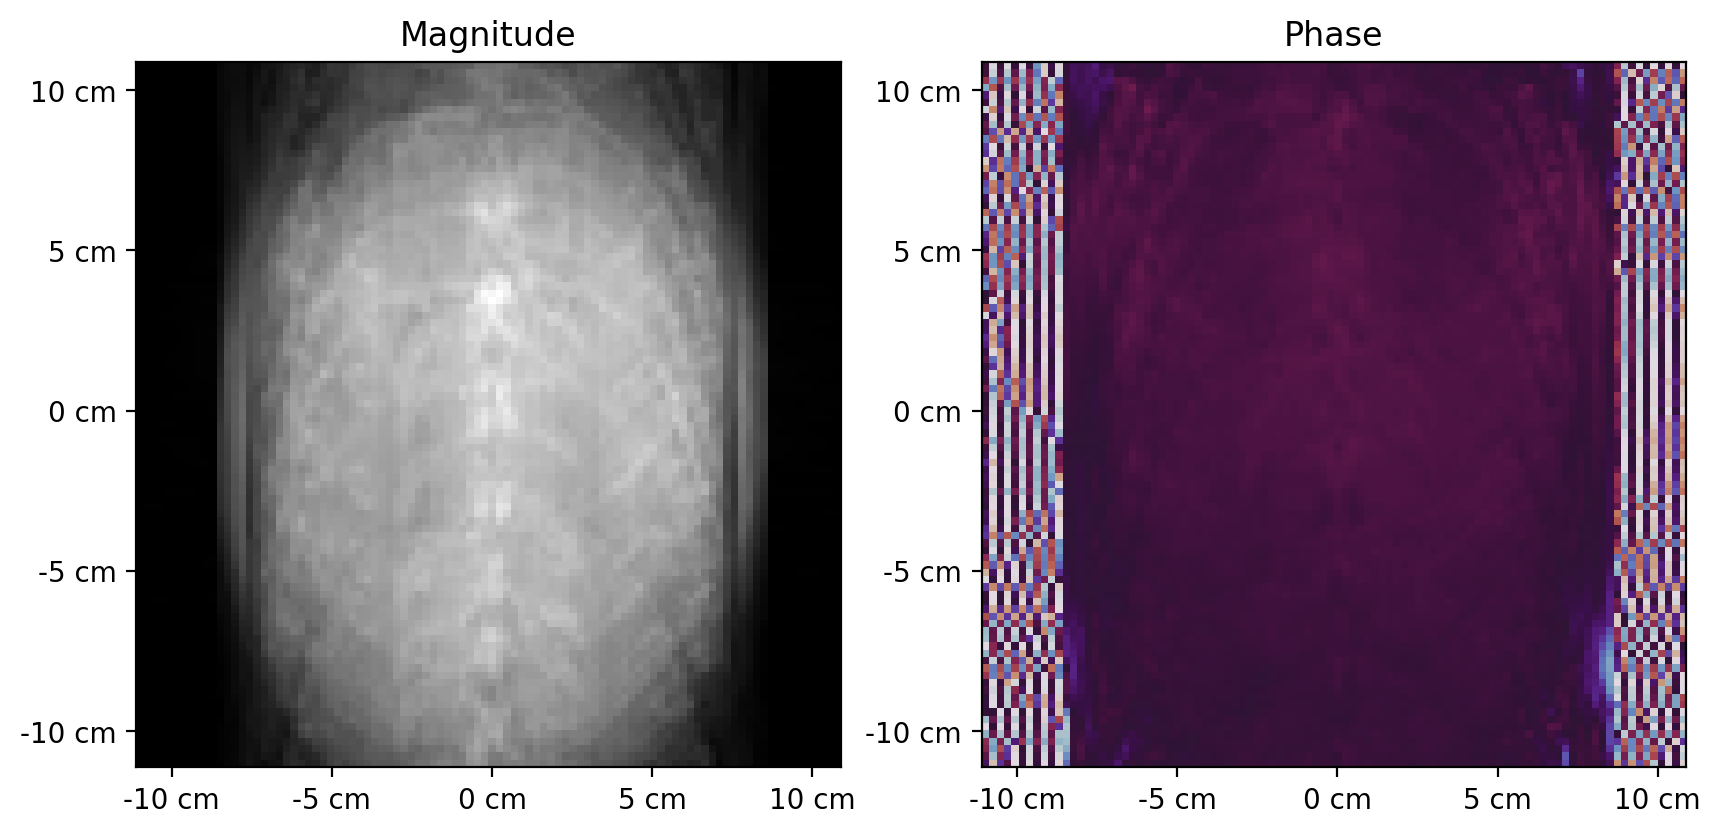

In [31]:
# PLOT
res = 96

def si(x):
    return (x / fov + 0.5) * res

reco = mr0.reco_adjoint(signal, seq0.get_kspace(), (res, res, 1), (0.2, 0.2, 1))[:, :, 0]
# reco = data_acs[:, :, 0]

plt.figure(figsize=(10, 5), dpi=200)
plt.subplot(121)
plt.title("Magnitude")
plt.imshow(reco.abs().cpu().T, origin='lower', vmin=0, cmap="gray")
plt.xticks([si(-0.1), si(-0.05), si(0), si(0.05), si(0.1)], ["-10 cm", "-5 cm", "0 cm", "5 cm", "10 cm"])
plt.yticks([si(-0.1), si(-0.05), si(0), si(0.05), si(0.1)], ["-10 cm", "-5 cm", "0 cm", "5 cm", "10 cm"])
plt.subplot(122)
plt.title("Phase")
plt.imshow(reco.angle().cpu().T, origin='lower', vmin=-torch.pi, vmax=torch.pi, cmap="twilight")
plt.xticks([si(-0.1), si(-0.05), si(0), si(0.05), si(0.1)], ["-10 cm", "-5 cm", "0 cm", "5 cm", "10 cm"])
plt.yticks([si(-0.1), si(-0.05), si(0), si(0.05), si(0.1)], ["-10 cm", "-5 cm", "0 cm", "5 cm", "10 cm"])
plt.show()

In [7]:
def to_full(x):
    tmp = torch.full(mask.shape, float("NaN"), dtype=torch.cfloat)
    tmp[mask] = x.to(torch.cfloat)
    return tmp

mag = [to_full(sum(rep).cpu()) for rep in mag_p]

img = torch.zeros(960, 960)
for i in range(len(mag)):
    img[(i%10)*96:(i%10)*96+96, (i//10)*96:(i//10)*96+96] = mag[i]

plt.figure(dpi=200)
plt.imshow(img.angle().T, origin="lower", vmin=-np.pi, vmax=np.pi, cmap="twilight")
plt.axis("off")
plt.show()

TypeError: unsupported operand type(s) for +: 'int' and 'list'

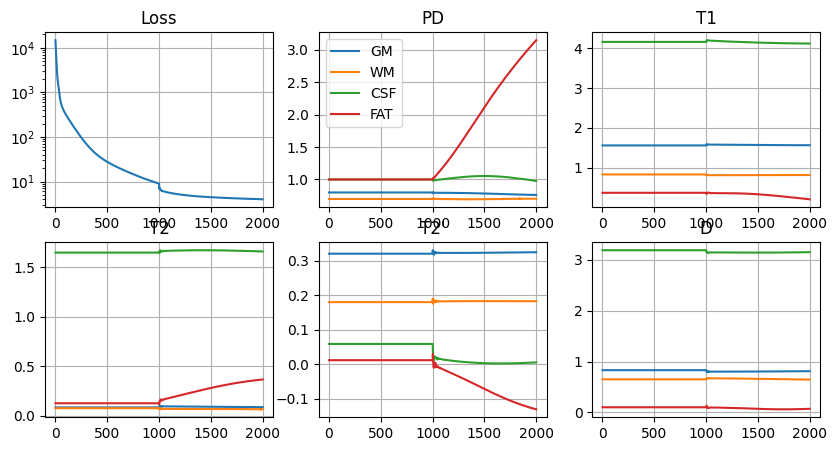

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


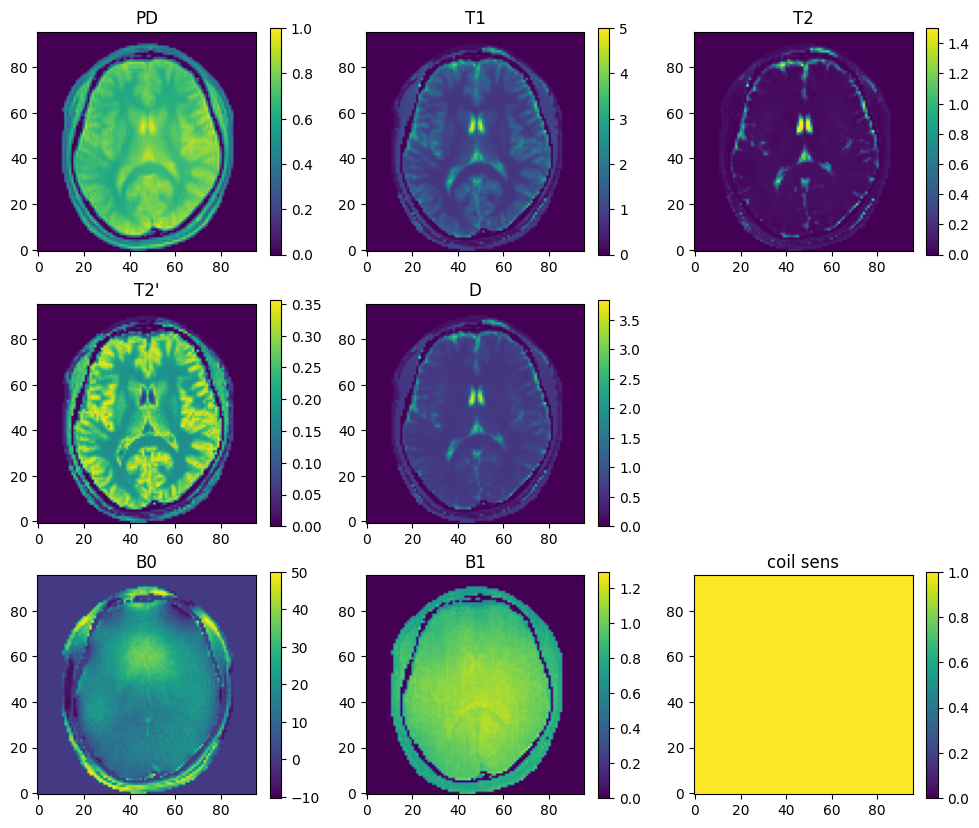

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


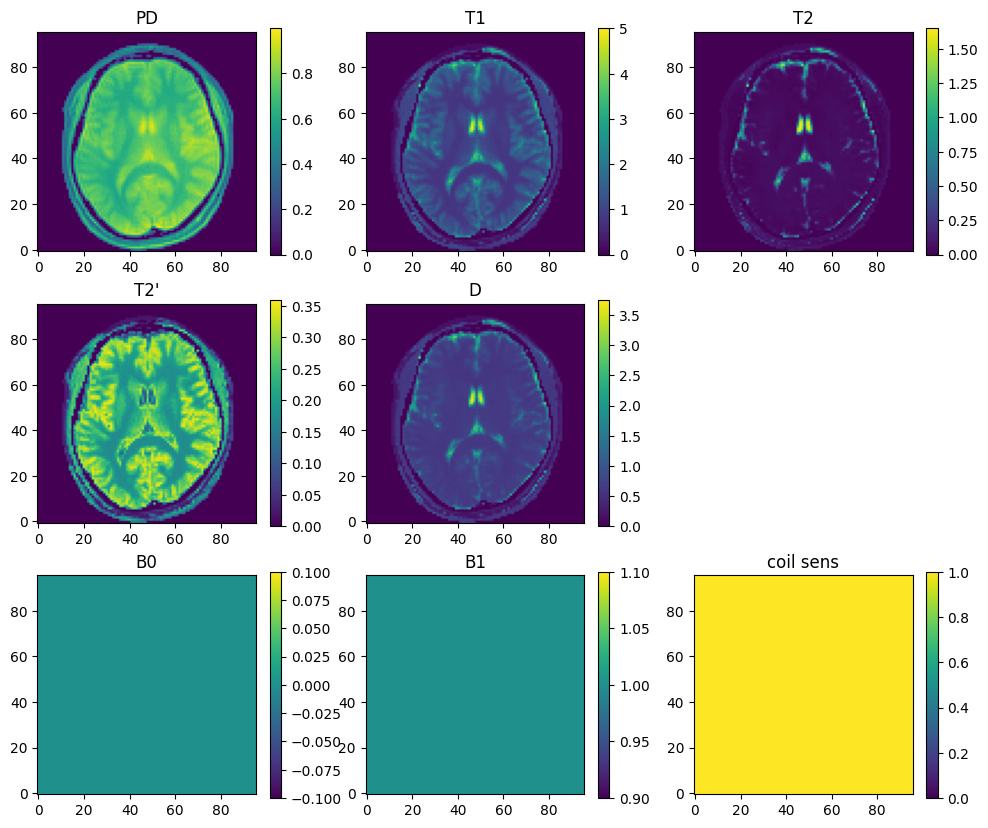

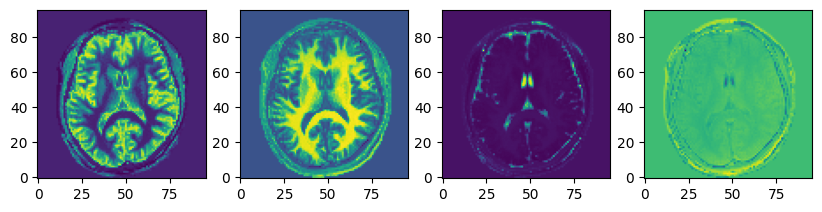

In [8]:
# Try to segment Nam
mask = nam_phantom.PD > 0

gm = torch.zeros(96, 96, 1)
wm = torch.zeros(96, 96, 1)
csf = torch.zeros(96, 96, 1)
fat = torch.zeros(96, 96, 1)

pd = torch.tensor([0.8, 0.7, 1, 1])
t1 = torch.tensor([1.56, 0.83, 4.16, 0.37])
t2 = torch.tensor([0.083, 0.075, 1.65, 0.125])
t2dash = torch.tensor([0.32, 0.18, 0.059, 0.012])
d = torch.tensor([0.83, 0.65, 3.19, 0.1])

segmentation = [gm, wm, csf, fat, pd, t1, t2, t2dash, d]

def loss_func(params):
    pd_diff = sum(params[i] * params[4][i] for i in range(4)) - nam_phantom.PD
    t1_diff = sum(params[i] * params[5][i] for i in range(4)) - nam_phantom.T1
    t2_diff = sum(params[i] * params[6][i] for i in range(4)) - nam_phantom.T2
    t2dash_diff = sum(params[i] * params[7][i] for i in range(4)) - nam_phantom.T2dash
    d_diff = sum(params[i] * params[8][i] for i in range(4)) - nam_phantom.D

    # Additional loss that encourages values at 0 and 1 with a power 4 polynomial
    seg_loss = sum((tissue**2 * (tissue - 1)**2).mean() for tissue in params[:4])

    diffs = [pd_diff, t1_diff, t2_diff, t2dash_diff, d_diff]
    return sum((diff[mask]**2).sum() for diff in diffs) + 100 * seg_loss


def build_phantom(params):
    tmp = [param.detach().cpu() for param in params]
    PD = sum(tmp[i] * tmp[4][i] for i in range(4))
    PD[~mask] = 0
    T1 = sum(tmp[i] * tmp[5][i] for i in range(4))
    T2 = sum(tmp[i] * tmp[6][i] for i in range(4))
    T2dash = sum(tmp[i] * tmp[7][i] for i in range(4))
    D = sum(tmp[i] * tmp[8][i] for i in range(4))

    B0 = torch.zeros(mask.shape)
    B1 = torch.ones(1, *mask.shape)
    coil_sens = torch.ones(1, *mask.shape)

    return mr0.VoxelGridPhantom(PD, T1, T2, T2dash, D, B0, B1, coil_sens, torch.tensor([0.2, 0.2, 0.008]))


for param in segmentation[:4]:
    param.requires_grad = True

loss_hist = []
pd_hist = []
t1_hist = []
t2_hist = []
t2dash_hist = []
d_hist = []

optimizer = torch.optim.Adam(
    [{"params": param, "lr": 0.01} for param in segmentation]
)
for i in range(2000):
    if i == 1000:
        for param in segmentation[4:]:
            param.requires_grad = True

    optimizer.zero_grad()
    loss = loss_func(segmentation)
    loss_hist.append(loss.detach().item())
    pd_hist.append(pd.detach().tolist())
    t1_hist.append(t1.detach().tolist())
    t2_hist.append(t2.detach().tolist())
    t2dash_hist.append(t2dash.detach().tolist())
    d_hist.append(d.detach().tolist())
    loss.backward()
    optimizer.step()

plt.figure()
plt.subplot(231)
plt.title("Loss")
plt.semilogy(loss_hist)
plt.grid()
plt.subplot(232)
plt.title("PD")
plt.plot([pd[0] for pd in pd_hist], label="GM")
plt.plot([pd[1] for pd in pd_hist], label="WM")
plt.plot([pd[2] for pd in pd_hist], label="CSF")
plt.plot([pd[3] for pd in pd_hist], label="FAT")
plt.legend()
plt.grid()
plt.subplot(233)
plt.title("T1")
plt.plot(t1_hist)
plt.grid()
plt.subplot(234)
plt.title("T2")
plt.plot(t2_hist)
plt.grid()
plt.subplot(235)
plt.title("T2'")
plt.plot(t2dash_hist)
plt.grid()
plt.subplot(236)
plt.title("D")
plt.plot(d_hist)
plt.grid()
plt.show()

nam_phantom.plot()
build_phantom(segmentation).plot()
plt.figure()
plt.subplot(141)
plt.imshow(gm.detach()[:, :, 0].T, origin="lower")
plt.subplot(142)
plt.imshow(wm.detach()[:, :, 0].T, origin="lower")
plt.subplot(143)
plt.imshow(csf.detach()[:, :, 0].T, origin="lower")
plt.subplot(144)
plt.imshow(fat.detach()[:, :, 0].T, origin="lower")
plt.show()